<a href="https://colab.research.google.com/github/LuppeCh/F1EDA/blob/Avance_1/Exploraci%C3%B3n_de_Datos_Trabajo_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
install.packages("dplyr")
install.packages("ggplot2")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [9]:
library(dplyr)
library(ggplot2)

In [10]:
wil <- read.csv("williams.csv", header = TRUE, dec = ".", sep = "\t")

In [11]:
head(wil)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,0,0,0,1,0,0.513507,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,0,0,1,1,0,1.449180,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,0,0,2,1,0,2.384850,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,0,0,3,1,0,3.320510,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,0,0,4,1,0,4.256180,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,0,0,5,1,0,5.194280,⋯,0,0,0,0,0,0,0,0,0,0


In [12]:
wil$carId <- "WIL"

In [13]:
tail(wil)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,WIL,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,WIL,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,WIL,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,WIL,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,WIL,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,WIL,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


Observamos que lapNum tiene un valor mayor al esperado (4), ya que arranca a contabilizar las vueltas desde 0, por lo que el lapNum = 5 corresponderia a la vuelta 6. Además observamos que los valores de muchas variables toman el valor "-1", lo cual es inconsistente en algunas variables como "lap_distance", por lo que aunque debemos eliminar todos los registros de esta vuelta, vamos a realizar un breve análisis que nos permita comprender que sucedió.

In [14]:
wil <- wil %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

Para trabajar más cómodos, decidimos eliminar todas aquellas columnas que no vamos a utilizar ni ahora ni a futuro.

In [15]:
inconsistencia <- wil %>%

  select(where(is.numeric)) %>%

  summarise(
    across(
      everything(),
      ~ sum(. == -1, na.rm = TRUE)
    )
  )

inconsistencia

lapNum,lap_time,lap_distance,lap_time_invalid,binIndex,velocity_X,velocity_Y,velocity_Z
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,3237,3237,3237,0,3237,3237,3237


Creamos un pequeño dataset que nos permite ver cuantas de las variables númericas existentes en nuestro dataset tienen un valor igual a "-1". Al imprimirla observamos que 6 de las 8 variables tienen 3237 registros de este tipo. Sospechamos que cuando una de estas variables toma el valor -1, las otras 5 también.

In [16]:
sospechosas <- c(
  "lap_time",
  "lap_distance",
  "lap_time_invalid",
  "velocity_X",
  "velocity_Y",
  "velocity_Z"
)


conteo_sospechosas <- wil %>%
  summarise(
    cant_sospechosas = sum(if_all(all_of(sospechosas), ~ . == -1), na.rm = TRUE)
  ) %>%
  pull()

conteo_sospechosas

[1] 3237

Se confirma nuestra teoría. Además, por lo leído en el archivo de especificaciones de EA SPORTS F1, este valor suele significar que no se ha cruzado la línea de meta, lo que puede indicar que estos valores pertenezcan a:

1. Una vuelta de calentamiento.
2. Los metros que sigue recorriendo el automóvil antes de frenar, luego de cruzar la meta.

In [17]:
final_valido <- wil %>%
  filter(lapNum == 5) %>%
  group_by(lap_time_invalid) %>%
  summarise(
    N_Registros = n(),
    .groups = 'drop'
  )

  final_valido

lap_time_invalid,N_Registros
<int>,<int>
-1,3237
0,1057


Confirmamos que todos estos valores pertenecen a la vuelta 6 (lapNum = 5), lo que indicaria que todos estos registros se deben a la razón 2.

In [18]:
wil <- wil %>%
  filter(lapNum < 5)

Borramos esta vuelta.

In [19]:
mcl <- read.csv("mcclaren.csv", header = TRUE, dec = ".", sep = "\t")

In [20]:
head(mcl)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,21,0,0,1,21,0.40625,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,21,0,1,1,21,1.41602,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,21,0,2,1,21,2.42578,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,21,0,3,1,21,3.43555,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,21,0,4,1,21,4.44531,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,21,0,5,1,21,5.45703,⋯,0,0,0,0,0,0,0,0,0,0


In [21]:
mcl$carId <- "MCL"

In [22]:
mcl$lapNum <- mcl$lapNum - 21

In [23]:
tail(mcl)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,MCL,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,MCL,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,MCL,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,MCL,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,MCL,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,MCL,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [24]:
mcl <- mcl %>%
  filter(lapNum < 5)

In [25]:
mcl <- mcl %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [26]:
red <- read.csv("redbull.csv", header = TRUE, dec = ".", sep = "\t")

In [27]:
head(red)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,16,0,0,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,16,0,1,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,16,0,2,1,16,2.81250,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,16,0,3,1,16,3.82617,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,16,0,4,1,16,4.83984,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,16,0,5,1,16,5.85352,⋯,0,0,0,0,0,0,0,0,0,0


In [28]:
red$carId <-"RED"

In [29]:
red$lapNum <- red$lapNum - 16

In [30]:
tail(red)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,RED,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,RED,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,RED,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,RED,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,RED,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,RED,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [31]:
red <- red %>%
  filter(lapNum < 5)

In [32]:
red <- red %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [33]:
alp <- read.csv("alpine.csv", header = TRUE, dec = ".", sep = "\t")

In [34]:
head(alp)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,10,0,0,1,10,1.63281,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,10,0,1,1,10,1.63281,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,10,0,2,1,10,2.62500,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,10,0,3,1,10,3.61719,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,10,0,4,1,10,4.60938,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,10,0,5,1,10,5.60156,⋯,0,0,0,0,0,0,0,0,0,0


In [35]:
alp$carId <- "ALP"

In [36]:
alp$lapNum <- alp$lapNum - 10

In [37]:
tail(alp)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
30053,ALP,Interlagos,4294,6,6,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30054,ALP,Interlagos,4294,6,6,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30055,ALP,Interlagos,4294,6,6,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30056,ALP,Interlagos,4294,6,6,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30057,ALP,Interlagos,4294,6,6,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
30058,ALP,Interlagos,4294,6,6,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [38]:
alp <- alp %>%
  filter(lapNum < 5)

In [39]:
alp <- alp %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [40]:
mer <- read.csv("mercedes.csv", header = TRUE, dec = ".", sep = "\t")

In [41]:
head(mer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,5,0,0,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,5,0,1,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,5,0,2,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,5,0,3,1,5,3.34570,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,5,0,4,1,5,4.41357,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,5,0,5,1,5,5.48145,⋯,0,0,0,0,0,0,0,0,0,0


In [42]:
mer$carId <-"MER"

In [43]:
mer$lapNum <- mer$lapNum - 5

In [44]:
tail(mer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
25759,MER,Interlagos,4294,5,5,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25760,MER,Interlagos,4294,5,5,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25761,MER,Interlagos,4294,5,5,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25762,MER,Interlagos,4294,5,5,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25763,MER,Interlagos,4294,5,5,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
25764,MER,Interlagos,4294,5,5,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [45]:
mer <- mer %>%
  filter(lapNum < 5)

In [46]:
mer <- mer %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [47]:
mer <- mer %>%
  mutate(
    sector = case_when(
      binIndex >= 0 & binIndex <= 1430 ~ "S1",
      binIndex >= 1431 & binIndex <= 2861 ~ "S2",
      binIndex >= 2862 & binIndex <= 4293 ~ "S3",
    ))

In [48]:
fer <- read.csv("ferrari.csv", header = TRUE, dec = ".", sep = "\t")

In [49]:
head(fer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Alpine,Interlagos,4294,0,31,0,0,1,31,0.93750,⋯,0,0,0,0,0,0,0,0,0,0
2,Alpine,Interlagos,4294,0,31,0,1,1,31,1.80313,⋯,0,0,0,0,0,0,0,0,0,0
3,Alpine,Interlagos,4294,0,31,0,2,1,31,2.66875,⋯,0,0,0,0,0,0,0,0,0,0
4,Alpine,Interlagos,4294,0,31,0,3,1,31,3.53438,⋯,0,0,0,0,0,0,0,0,0,0
5,Alpine,Interlagos,4294,0,31,0,4,1,31,4.40000,⋯,0,0,0,0,0,0,0,0,0,0
6,Alpine,Interlagos,4294,0,31,0,5,1,31,5.26562,⋯,0,0,0,0,0,0,0,0,0,0


In [50]:
fer$carId <- "FER"

In [51]:
fer$lapNum <- fer$lapNum - 31

In [52]:
tail(fer)

,carId,trackId,trackLength,lapIndex,lapNum,lapFlag,binIndex,validBin,lap_number,lap_distance,⋯,gear_box_damage,engine_damage,mguh_damage,es_damage,ce_damage,ice_damage,mguk_damage,tc_damage,engine_blown,engine_seized
,<chr>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
21465,FER,Interlagos,4294,4,4,0,4288,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21466,FER,Interlagos,4294,4,4,0,4289,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21467,FER,Interlagos,4294,4,4,0,4290,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21468,FER,Interlagos,4294,4,4,0,4291,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21469,FER,Interlagos,4294,4,4,0,4292,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
21470,FER,Interlagos,4294,4,4,0,4293,0,-1,-1,⋯,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


En este caso si tenemos la cantidad correcta de vueltas, pero como podemos ver hay muchisimos valores "-1", por lo que debemos borrar esta vuelta y generarla de manera artificial.

In [53]:
fer <- fer %>%
  filter(lapNum < 4)

In [54]:
fer <- fer %>%
  select(
    carId,
    lapNum,
    lap_time,
    lap_distance,
    lap_time_invalid,
    binIndex,
    velocity_X,
    velocity_Y,
    velocity_Z
  )

In [55]:
vueltas_anuladas_fer <- fer %>%
  group_by(lapNum) %>%
  summarise(lap_time_invalid = max(lap_time_invalid))

Para generar de forma artificial la quinta vuelta, debemos realizarlo promediando los valores de las vueltas validas, por lo que visualizamos cuales son (las que tienen lap_time_valid = 0)

In [56]:
vueltas_anuladas_fer

lapNum,lap_time_invalid
<dbl>,<int>
0,0
1,1
2,1
3,0


Solamente podemos trabajar con la vuelta 1 y 4.

In [57]:
vueltas_validas <- fer %>%
  filter(lapNum %in% c(0, 3))

In [58]:
vuelta_5 <- vueltas_validas %>%
  group_by(binIndex) %>%
  summarise(
    lap_distance = mean(lap_distance, na.rm = TRUE),
    lap_time = mean(lap_time, na.rm = TRUE),
    velocity_X = mean(velocity_X, na.rm = TRUE),
    velocity_Y = mean(velocity_Y, na.rm = TRUE),
    velocity_Z = mean(velocity_Z, na.rm = TRUE),

    carId = "FER",
    lap_time_invalid = 0
  ) %>%

  ungroup()%>%

  mutate(
    lapNum = 4
  )

Las filtramos en el dataset "vueltas_validas" y construimos la "vuelta_5" calculando los promedios en la variables indicadas, despues le pasamos el valor del id, que la vuelta es valida y que es la número 5.

In [59]:
fer <- bind_rows(fer, vuelta_5)

La agregamos a nuestro dataset de ferrari.

In [60]:
telemetria <- bind_rows(fer, red, mcl, mer, alp, wil)

Únimos los 6 datasets en uno único.

In [61]:
telemetria <- telemetria %>%
  mutate(
    sector = case_when(
      binIndex >= 0 & binIndex <= 1430 ~ "S1",
      binIndex >= 1431 & binIndex <= 2861 ~ "S2",
      binIndex >= 2862 & binIndex <= 4293 ~ "S3",
    ),
    track_lenght = 4294
    )

Creamos la columna sector, indicando el valor que toma según el binIndex.

In [62]:
telemetria <- telemetria %>%
  mutate(
    velocity_total_ms = sqrt(
      velocity_X^2 +
      velocity_Y^2 +
      velocity_Z^2
    ),

    velocidad = velocity_total_ms * 3.6
  )

telemetria <- telemetria %>%
  select(-velocity_total_ms)

In [63]:
inconsistencia_global <- telemetria %>%

  select(where(is.numeric)) %>%

  summarise(
    across(
      everything(),
      ~ sum(. == -1, na.rm = TRUE)
    )
  )

inconsistencia_global

lapNum,lap_time,lap_distance,lap_time_invalid,binIndex,velocity_X,velocity_Y,velocity_Z,track_lenght,velocidad
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0


In [64]:
telemetria <- telemetria %>%
  mutate(lap_number = lapNum + 1)

In [65]:
registros <- nrow(telemetria)
print(paste("cant. registros:", registros))

escuderias <- unique(telemetria$carId)
print(escuderias)

cant_lap <- unique(telemetria$lapNum)
print(cant_lap)

cant_lap <- unique(telemetria$lap_number)
print(cant_lap)

any(is.na(telemetria))

[1] "cant. registros: 128820"
[1] "FER" "RED" "MCL" "MER" "ALP" "WIL"
[1] 0 1 2 3 4
[1] 1 2 3 4 5


[1] FALSE

In [73]:
options(repr.plot.width = 20, repr.plot.height = 14)

# ETAPA 2A

A continuación, elaboramos un gráfico que muestra el tiempo por vuelta de cada escudería.

In [82]:
lap_times_summary <- telemetria %>%
  group_by(carId, lap_number) %>%
  summarise(total_lap_time = max(lap_time, na.rm = TRUE), .groups = 'drop')

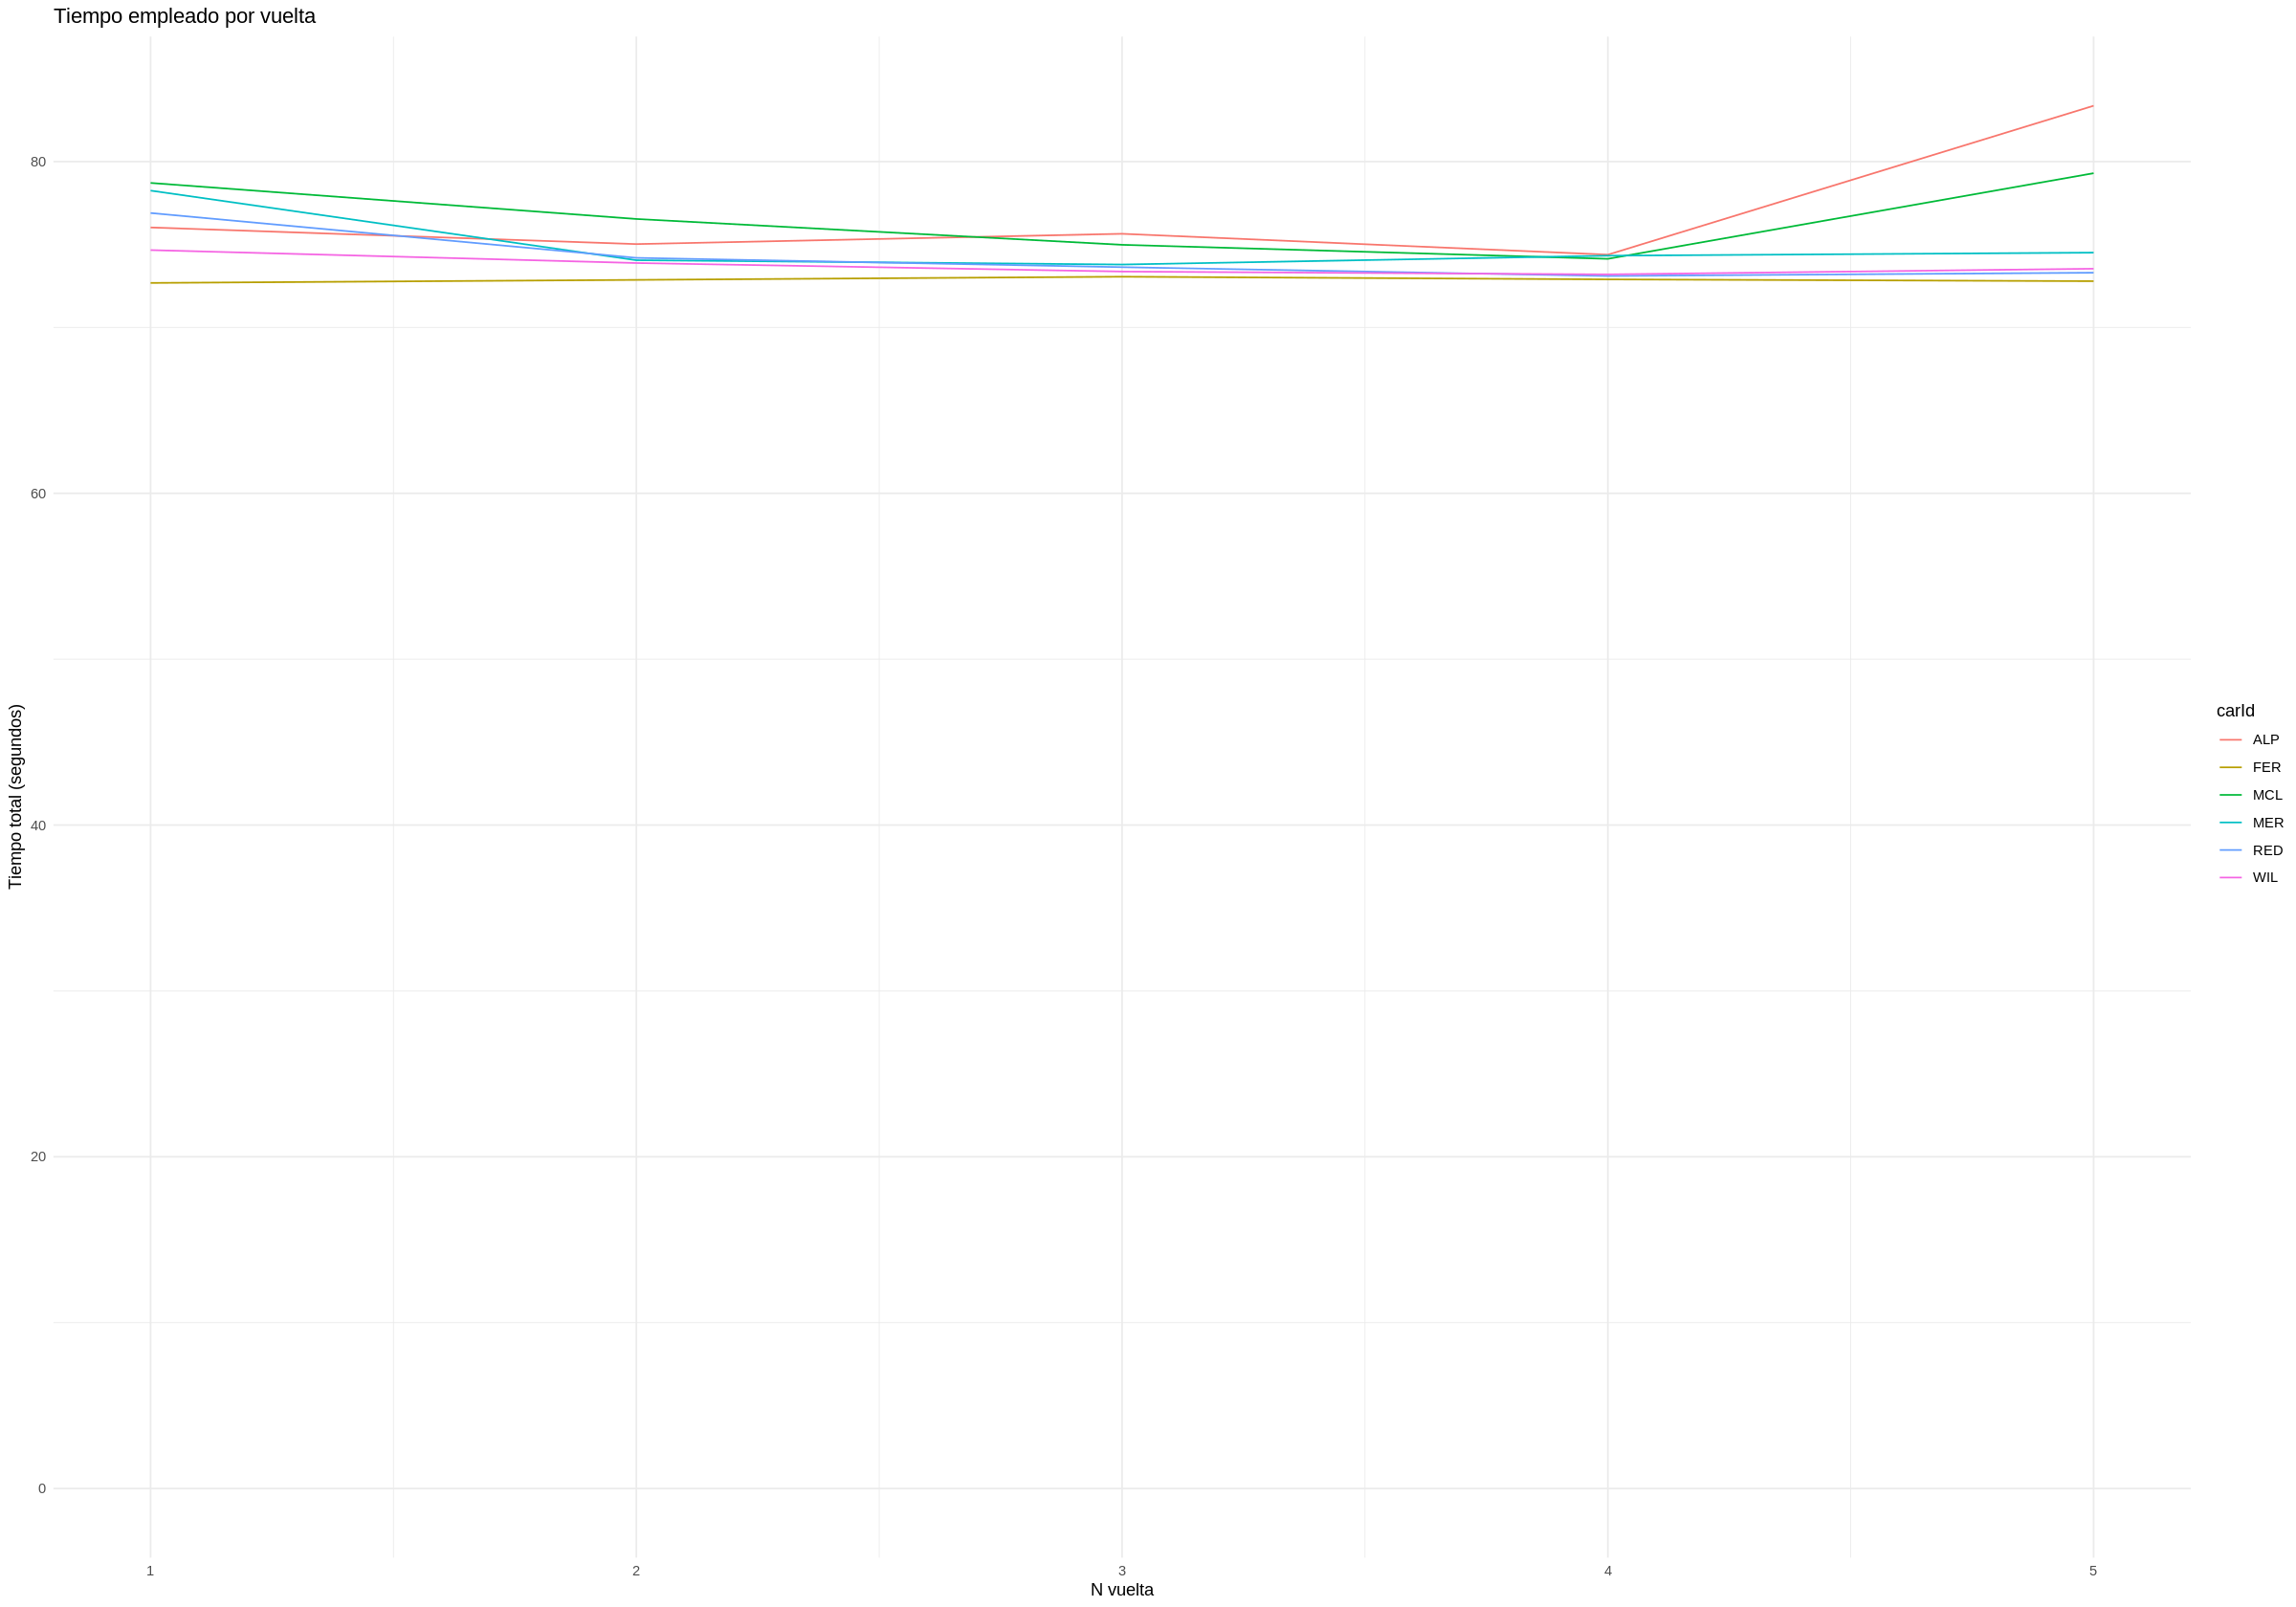

In [83]:
ggplot(lap_times_summary, aes(x = lap_number, y = total_lap_time, color = carId)) +
  geom_line() +
  labs(
    title = "Tiempo empleado por vuelta",
    x = "N vuelta",
    y = "Tiempo total (segundos)"
  ) +
  ylim(0, NA) +
  theme_minimal()

In [84]:
print(lap_times_summary)

# A tibble: 30 × 3
   carId lap_number total_lap_time
   <chr>      <dbl>          <dbl>
 1 ALP            1           76.0
 2 ALP            2           75.0
 3 ALP            3           75.6
 4 ALP            4           74.4
 5 ALP            5           83.4
 6 FER            1           72.7
 7 FER            2           72.9
 8 FER            3           73.1
 9 FER            4           72.9
10 FER            5           72.8
# ℹ 20 more rows


El gráfico de nos permite observar el rendimiento de cada escudería a lo largo de cinco vueltas.


*   **Ferrari** y **Red Bull** demuestran ser las escuderías con los tiempos de vuelta más consistentes y rápidos en general, manteniéndose alrededor de los 72-73 segundos por vuelta.

*   **Mercedes** también exhibe un rendimiento sólido y consistente, con tiempos de vuelta ligeramente superiores a Ferrari y Red Bull, pero muy estables.

*   **McLaren** y **Williams** muestran tiempos de vuelta competitivos en las primeras vueltas, pero Williams presenta una leve tendencia a aumentar sus tiempos en las últimas vueltas válidas.

*   **Alpine** presenta una anomalía significativa en la vuelta 5, donde su tiempo total de vuelta se dispara a 83.4 segundos, mientras que el resto de sus vueltas están en el rango de 74-76 segundos.

*   La **consistencia** es una característica notable para la mayoría de las escuderías en sus vueltas válidas (1 a 4), lo que indica un rendimiento estable bajo condiciones de carrera normales.